# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
#!pip install Cython
#!pip uninstall -y params
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
#!pip install scipy
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [3]:
!python --version

Python 3.12.4


In [4]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

import sys
sys.path.append('./hifi-gan')
from env import AttrDict
from models import Generator as HiFiGAN
print('Done')

ModuleNotFoundError: No module named 'voice_cloning'

In [2]:
N_SPKS = 247  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)

In [ ]:
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(torch.load('/repo/voice-cloning/voice_cloning/Grad-TTS/logs/new_exp/spk_grad_3.pt', map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./resources/cmu_dictionary')

NameError: name 'GradTTS' is not defined

In [17]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


In [18]:
text = "Here are the match lineups for the Colombia Haiti match."

In [19]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 97]), tensor([97], device='cuda:0'))

Grad-TTS RTF: 1.5947749019058295


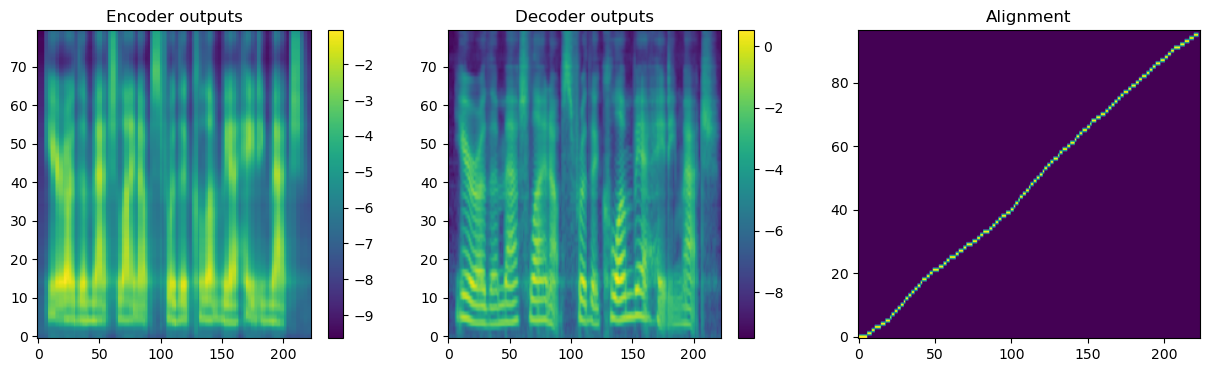

In [20]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

In [21]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

In [26]:
from model.text_encoder import TextEncoder
gen2 = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)
gen2.load_state_dict(torch.load('./checkpts/grad-tts-libri-tts.pt', map_location=lambda loc, storage: loc))

gen2.encoder = TextEncoder(gen2.n_vocab, gen2.n_feats, gen2.n_enc_channels,
                           gen2.filter_channels, gen2.filter_channels_dp, gen2.n_heads,
                           gen2.n_enc_layers, gen2.enc_kernel, gen2.enc_dropout, gen2.window_size)
torch.save(gen2.state_dict(), './checkpts/trained_decoder.pt')